In [ ]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import mean_squared_error, r2_score

# Mount Drive, read file
from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv('/content/drive/MyDrive/aML/airbnb.csv')

Mounted at /content/drive


In [ ]:
# One-hot Encoding for city
df_encoded = pd.get_dummies(df, columns=['city'], prefix='city')

# Binary Encoding for time_period
df_encoded['is_weekend'] = (df_encoded['time_period'] == 'weekends').astype(int)

# Create combined stratification column
df_encoded['strat_column'] = df['city'] + '_' + df['time_period']

#Define features and target
X = df_encoded.drop(['price', 'log_price', 'time_period', 'strat_column'], axis=1)
y = df_encoded['log_price']

#Stratification split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=df_encoded['strat_column']
)

**Training Baseline kNN Regressor without Scaling**

In [ ]:
knn = KNeighborsRegressor()
knn.fit(X_train, y_train)

print("Score of non-scaled Regressor on training set: {:.3f}".format(knn.score(X_train, y_train)))
print("Score non-scaled Regressor on test set: {:.3f}".format(knn.score(X_test, y_test)))

Score of non-scaled Regressor on training set: 0.776
Score non-scaled Regressor on test set: 0.663


In [ ]:
# Scaling both Standard and Robust to Compare
scaler = StandardScaler()
robust_scaler = RobustScaler()

numerical_cols = ['person_capacity', 'cleanliness_rating',
                 'guest_satisfaction_overall', 'city_dist', 'metro_dist']

X_train_scaled = scaler.fit_transform(X_train[numerical_cols])
X_test_scaled = scaler.transform(X_test[numerical_cols])

X_train_robust = robust_scaler.fit_transform(X_train[numerical_cols])
X_test_robust = robust_scaler.transform(X_test[numerical_cols])

In [ ]:
from sklearn.pipeline import Pipeline

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsRegressor())
])


param_grid = {
    'scaler': [StandardScaler(),  RobustScaler(), 'passthrough'],
    'knn__n_neighbors': [3, 6, 12, 24, 48, 96],
    'knn__weights': ['uniform', 'distance'],
    'knn__p': [1, 2],
}

grid_search = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    cv=5,
    scoring='r2',
    return_train_score=True,
    verbose=3
)

grid_search.fit(X_train, y_train)

print("Best hyperparameter settings found: ", grid_search.best_params_)

best_model_knn = grid_search.best_estimator_

Fitting 3 folds for each of 72 candidates, totalling 216 fits
[CV 1/3] END knn__n_neighbors=3, knn__p=1, knn__weights=uniform, scaler=StandardScaler();, score=(train=0.835, test=0.658) total time=  11.8s
[CV 2/3] END knn__n_neighbors=3, knn__p=1, knn__weights=uniform, scaler=StandardScaler();, score=(train=0.834, test=0.669) total time=  10.4s
[CV 3/3] END knn__n_neighbors=3, knn__p=1, knn__weights=uniform, scaler=StandardScaler();, score=(train=0.837, test=0.666) total time=  13.9s
[CV 1/3] END knn__n_neighbors=3, knn__p=1, knn__weights=uniform, scaler=RobustScaler();, score=(train=0.833, test=0.644) total time=  11.9s
[CV 2/3] END knn__n_neighbors=3, knn__p=1, knn__weights=uniform, scaler=RobustScaler();, score=(train=0.832, test=0.650) total time=  11.6s
[CV 3/3] END knn__n_neighbors=3, knn__p=1, knn__weights=uniform, scaler=RobustScaler();, score=(train=0.834, test=0.660) total time=  11.8s
[CV 1/3] END knn__n_neighbors=3, knn__p=1, knn__weights=uniform, scaler=passthrough;, score=

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('knn', KNeighborsRegressor())]),
             param_grid={'knn__n_neighbors': [3, 6, 12, 24, 48, 96],
                         'knn__p': [1, 2],
                         'knn__weights': ['uniform', 'distance'],
                         'scaler': [StandardScaler(), RobustScaler(),
                                    'passthrough']},
             return_train_score=True, scoring='r2', verbose=3)

In [ ]:
print("Best hyperparameter settings found: ", grid_search.best_params_)

best_model_knn = grid_search.best_estimator_

Best hyperparameter settings found:  {'knn__n_neighbors': 24, 'knn__p': 1, 'knn__weights': 'distance', 'scaler': StandardScaler()}


Removed distance weights as continously train score of 1 and severe overfitting, trying again with limited improved param_grid but seems like knnRegressor underperforms RandomForestRegressor either way....

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5] END knn__n_neighbors=5, knn__p=1, knn__weights=uniform, preprocessor__num=StandardScaler();, score=(train=0.792, test=0.671) total time=   1.3s
[CV 2/5] END knn__n_neighbors=5, knn__p=1, knn__weights=uniform, preprocessor__num=StandardScaler();, score=(train=0.792, test=0.664) total time=   1.3s
[CV 3/5] END knn__n_neighbors=5, knn__p=1, knn__weights=uniform, preprocessor__num=StandardScaler();, score=(train=0.789, test=0.680) total time=   1.3s
[CV 4/5] END knn__n_neighbors=5, knn__p=1, knn__weights=uniform, preprocessor__num=StandardScaler();, score=(train=0.789, test=0.690) total time=   1.3s
[CV 5/5] END knn__n_neighbors=5, knn__p=1, knn__weights=uniform, preprocessor__num=StandardScaler();, score=(train=0.790, test=0.687) total time=   1.4s
[CV 1/5] END knn__n_neighbors=6, knn__p=1, knn__weights=uniform, preprocessor__num=StandardScaler();, score=(train=0.778, test=0.672) total time=   1.3s
[CV 2/5] END knn__n_ne

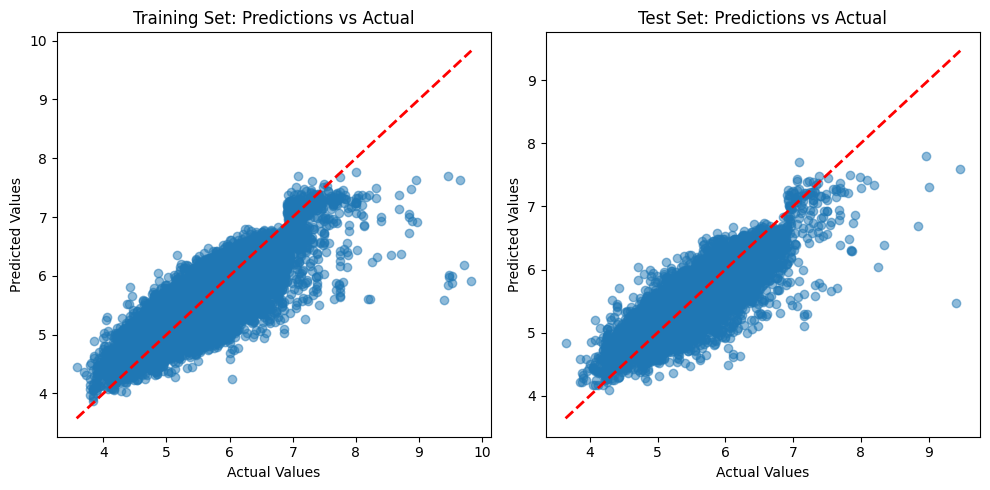

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

numerical_cols = ['person_capacity', 'cleanliness_rating',
                 'guest_satisfaction_overall', 'city_dist', 'metro_dist']

numeric_transformer = StandardScaler()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_cols)
    ],
    remainder='passthrough'
)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('knn', KNeighborsRegressor())
])

param_grid_improved = {
    'preprocessor__num': [StandardScaler()],
    'knn__n_neighbors': [5, 6, 7, 8, 9 ],
    'knn__weights': ['uniform'],
    'knn__p': [1]
}

grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid_improved,
    cv=5,
    scoring='r2',
    return_train_score=True,
    verbose=3
)

grid_search.fit(X_train, y_train)

print("\nBest parameters found:", grid_search.best_params_)
print("Best cross-validation R² score: {:.4f}".format(grid_search.best_score_))

best_model = grid_search.best_estimator_

y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
train_rmse = np.sqrt(train_mse)
test_rmse = np.sqrt(test_mse)

print("\nFinal Model Performance:")
print("\nTraining Set Metrics:")
print(f"R² Score: {train_r2:.4f}")
print(f"RMSE: {train_rmse:.4f}")

print("\nTest Set Metrics:")
print(f"R² Score: {test_r2:.4f}")
print(f"RMSE: {test_rmse:.4f}")

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.scatter(y_train, y_train_pred, alpha=0.5)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Training Set: Predictions vs Actual')

plt.subplot(1, 2, 2)
plt.scatter(y_test, y_test_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Test Set: Predictions vs Actual')

plt.tight_layout()
plt.show()